<div style="text-align: justify;">
    Do reprezentacji danych elipsometrycznych użyto dwóch klas: training_sample oraz training_dataset. Klasa training_sample opisuje pojedyńczy zestaw danych dotyczący jednej próbki. Zawiera on informacje o wartościach PSI oraz DELTA dla długości fal od 300 do 1000 z krokiem 10nm. Klasa training_dataset opisuje zaś zbiór próbek które można wykorzystać do uczenia modeli. Klasy te zakładają, że dane na temat próbki - tj. grubość, oraz współczynniki A, B, C są zawarte w nazwie pliku, z którego dane są wczytywane, zgodnie ze wzorem opisanym w poprzednim akapicie. W celu zachowania czytelności tekstu oraz przedstawienia działania funkcji znajdujących się w poszczególnych klasach, każda zastosowana funkcja której powstanie było wynikiem tej pracy zostanie przedstawiona przed wywołaniem jej w kodzie. Ze względu na brak natywnego wsparcia Jupyter Notebook dla importowania innych notatników do notatnika obecnie używanego, zastosowano bibliotekę `importnb`, która pozwala na importowanie innych notatników jako modułów Pythona. W celu poprawnego działania należy zainstalować tę bibliotekę, co można zrobić za pomocą polecenia `pip install importnb`. W celu dokonania analizy zbioru danych utworzono instancję klasy training_dataset. Konstruktor klasy training_dataset zamieszono poniżej.
</div>

In [1]:
def __init__(self, dataset_folder, col):
        """
        Initializes the training_dataset object by gathering training samples from the specified dataset folder.

        Parameters:
        - dataset_folder: str, the path to the folder containing the dataset files.
        - col: list, the columns to be used for processing the dataset.
        """
        self.samples = self.gather_samples(dataset_folder, col)
    

<div style="text-align: justify;">
    Jak widać funkcja ta przyjmuje jako argumenty datasets_folder - lokalizację zbioru danych które chcemy poddać analizie - oraz col - listę kolumn które znajdować się będą w pojedyńczej próbce należącej do zbioru danych. Poniżej importowane są istotne biblioteki. Biblioteka import_ipynb jest wykorzystywana do importowania innych notatników jako modułów Pythona, co pozwala na korzystanie z funkcji i klas zdefiniowanych w tych notatnikach.
Klasa training_dataset zawiera istotny dla nas kod. Klasa locations pozwala na uzyskanie ścieżek do plików istotnych dla projektu. Biblioteka os pozwala na wykonywanie operacji na ścieżkach do plików.
</div>

In [2]:
import import_ipynb
import training_dataset as td
import locations as l
import os

<div style="text-align: justify;">
    Pozyskujemy ścieżkę do interesującego nas zbioru danych oraz tworzymy obiekt training_dataset na jego podstawie.
</div>

In [3]:
l.locations.list_datasets()

['.ipynb_checkpoints',
 'half_new_Si_jaw_delta',
 'lifesat',
 'new_Si_jaw_delta',
 'quarter_new_Si_jaw_delta',
 'R2_comparison_2.ipynb',
 'si02',
 'Si_jaw',
 'Si_jaw_delta']

In [4]:
datasets_folder = l.locations.get_data_dir()
specific_dataset_location = os.path.join(datasets_folder, "new_Si_jaw_delta")
t_dataset = td.training_dataset(specific_dataset_location, col = ['wavelength', 'psi65', 'del65', 'psi70', 'del70', 'psi75', 'del75'])

<div style="text-align: justify;">
    Za pomocą funkcji plot_data() zawartej w klasie training_dataset możemy zwizualizować dane zawarte w zbiorze danych. Funkcja ta przyjmuje jako argumenty nazwy interesujących nas parametrów. Następnie pobiera one interesujące nas dane z każdej instancji training_sample i prezentuje je w postaci histogramu
</div>

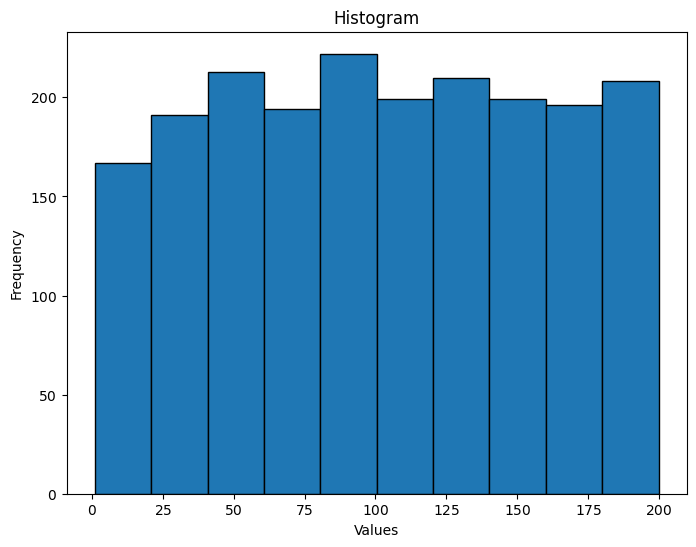

In [5]:
t_dataset.plot_histogram(["T"])

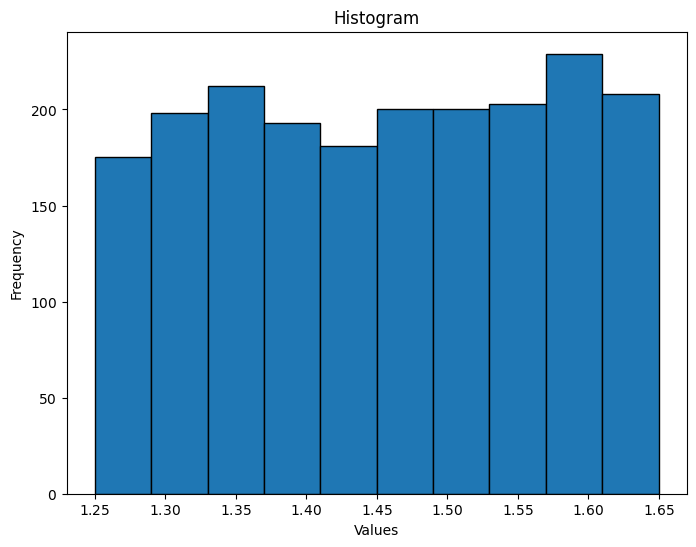

In [6]:
t_dataset.plot_histogram(["A"])

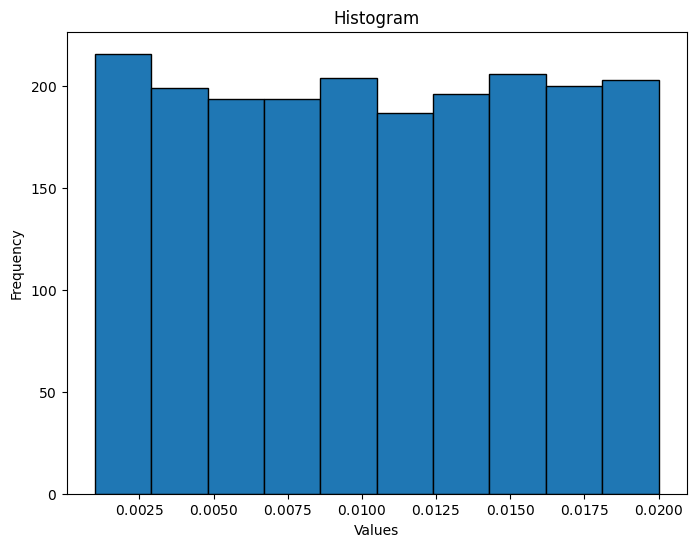

In [7]:
t_dataset.plot_histogram(["B"])

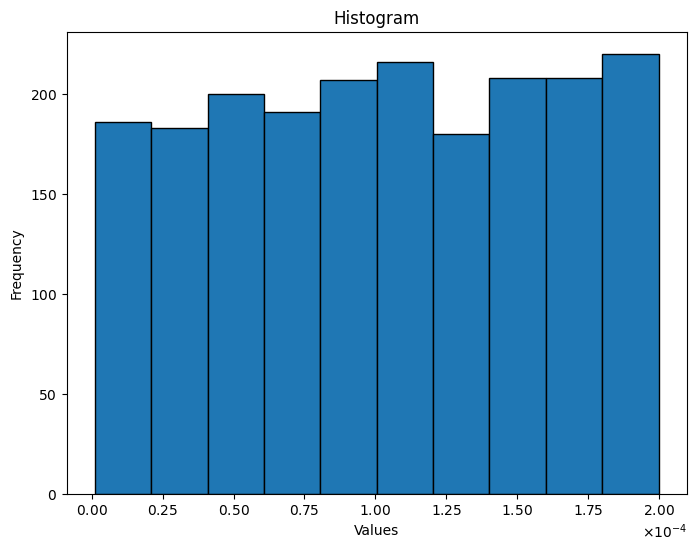

In [8]:
t_dataset.plot_histogram(["C"])

<div style="text-align: justify;">
    Jak widać dane rozłożone są w miarę równomiernie, co sprawia że nie jest konieczne zastosowanie algorytmów służących do usuwania odstających wartości. Przystępujemy do analizy danych za pomocą regresji liniowej. Analizy dokonujemy na dwa sposoby - pierwszy sposób polega na analizie poszczególnych wierszy zbioru danych - tj. podstawową jednostką która posłuży do wykonywania inferencji będzie pojedyńczy wiersz należący do próbki. Wiersz ten będzie się składać w długości fali, oraz wartości PSI i DELTA dla trzech różnych kątów padania wiązki. Drugi sposób polega na analizie całej próbki - tj. podstawową jednostką będzie pojedyńcza próbka, która będzie się składać z długości fali oraz wartości PSI i DELTA dla trzech kątów padania. W celu przedstawienia próbki w ten sposób użyto funkcji return_as_flat_df należącej do klasy training_sample oraz funkcji o zbliżonej konstrukcji które zwracają dane innego typu np. zwracają je w formie tensorów bądź listy zmiennych typu float. Funkcję return_as_flat_df przedstawiono poniżej:
</div>

In [9]:
def return_as_flat_df(self, feature_columns = ['wavelength', 'psi65', 'del65', 'psi70', 'del70', 'psi75', 'del75']
                      , target_columns = ['T', 'A', 'B', 'C']):
        """
        Flattens the features and targets into a single row and returns them as DataFrames.
    
        Parameters:
        - feature_columns: list, names of the columns to use as features.
        - target_columns: list, names of the columns to use as targets.
    
        Returns:
        - tuple: A tuple containing two pandas DataFrames (features, targets).
        """
        features = self.data[feature_columns]
        targets = self.data[target_columns]
        targets = targets.iloc[:1]
        features = features.values.reshape(1, -1)
        targets = targets.values.reshape(1, -1)
        features = pd.DataFrame(features)
        targets = pd.DataFrame(targets)
        return features, targets

<div style="text-align: justify;">
Przyjmuje ona jako argumenty listę kolumn z których wartości będziemy chcieli użyć podczas uczenia jako etykiety oraz listę kolumn z których wartości będziemy chcieli użyć jako cechy. Funkcja ta zwraca dwie ramki danych - pierwsza zawiera cechy, druga etykiety. Wartości w ramkach danych są spłaszczone, co oznacza że każda próbka jest reprezentowana jako pojedynczy wiersz. W obu przypadkach będziemy chcieli przewidzieć grubość warstwy SiO2, oraz współczynniki A, B, C. Regresję liniową przeprowadzimy za pomocą biblioteki scikit-learn, która jest jedną z najpopularniejszych bibliotek do uczenia maszynowego w Pythonie. Po utworzeniu instancji klasy, możemy ją przeprowadzić za pomocą funkcji, lin_reg, flat_lin_reg, lasso_reg, flat_lasso_reg, ridge_reg, flat_ridge_reg. Jako przykład omówimy funkcję lasso_lin_reg, ponieważ w przeciwieństwie do funkcji odpowiadającej za zwykłą regresję liniową, funkcja ta przyjmuja także jako parametr zmienną alpha. Wartość ta wpływa na funkcję kosztu poprzez penalizację wysokich wartości współczynników regresji, co pozwala na uniknięcie przeuczenia modelu. Wzór na funkcję kosztu regresji lasso przedstawiony jest poniżej:

</div>

$$
\text{Funkcja kosztu regresji lasso: } \frac{1}{2n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} |\beta_j|
$$

<div style="text-align: justify;">
Funkcję przeprowadzającą regresję typu lasso dla próbek przedstawionych jako pojedyńcze wiersze przedstawiono poniżej.
</div>

In [10]:
    def flat_lasso_reg(self, feature_columns=['wavelength', 'psi65', 'del65', 'psi70', 'del70', 'psi75', 'del75'], target_columns=['T'], test_size=0.2, random_state = 42, alpha = 0.1):
        # Split the dataset into training and testing sets
        data = self.flat_df_split(feature_columns, target_columns, test_size, random_state)
        
        # Initialize Lasso regression model
        lasso_reg = Lasso(alpha=alpha)
        
        # Fit the Lasso regression model on the training data
        lasso_reg.fit(data[0], data[2])
        
        # Predict on train and test sets
        pred_train = lasso_reg.predict(data[0])
        pred_test = lasso_reg.predict(data[1])
        
        # Calculate R² coefficients
        r2_train = r2_score(data[2], pred_train)
        r2_test = r2_score(data[3], pred_test)
        
        # Print R² coefficients
        print(f"Train R²: {r2_train}")
        print(f"Test R²: {r2_test}")
        
        # Return R² coefficients as a dictionary
        return {"train_r2": r2_train, "test_r2": r2_test, "coefficients": lasso_reg.coeff_}

<div style="text-align: justify;">
Funkcja ta przyjmuje jako argument listę kolumn z których wartości będziemy chcieli użyć podczas uczenia jako cechy, listę kolumn z których wartości będziemy chcieli użyć jako etykiety, rozmiar zbioru testowego, wartość random_state oraz wartość alpha. Funkcja ta dzieli zbiór danych na zbiór treningowy i testowy, następnie tworzy model regresji lasso, uczy go na zbiorze treningowym i dokonuje predykcji na zbiorze treningowym i testowym. Na końcu funkcja ta zwraca współczynnik determinacji R² dla zbioru treningowego i testowego oraz współczynniki regresji. Poniżej zamieszczono tabelę zawierającą wyniki różnych rodzajów regresji dla wybranych wartości alpha z wykorzystaniem różnych rodzajów regresji.
</div>

In [22]:
{tabela}

NameError: name 'tabela' is not defined

<div style="text-align: justify;">
Jak widać, współczynniki determinacji uzyskane za pomocą regresji liniowej oraz jej wariacji są dalekie od zadowalających. Największą korelację możemy zauważyć dla wartości T oraz A, ale dane wyniki dla wartości B i C nie są zadowalające. Wartości te są bardzo niskie, co sugeruje że model nie jest w stanie dobrze przewidzieć tych wartości na podstawie dostępnych danych. W celu poprawy wyników można by spróbować zastosować inne metody regresji, takie jak regresja wielomianowa, czy też regresja z użyciem drzew decyzyjnych. W dalszej części tej pracy opisane będzie jednak podejście oparte o wykorzystanie sieci neuronowych.
</div>

<div style="text-align: justify;">
W celu tworzenia modeli sieci neuronowych utworzono klasę MLP znajdującą się w notatniku model_creator. Klasa ta pozwala na tworzenie modeli sieci neuronowych z wykorzystaniem biblioteki PyTorch. Konstruktor klasy pozwala 

</div>